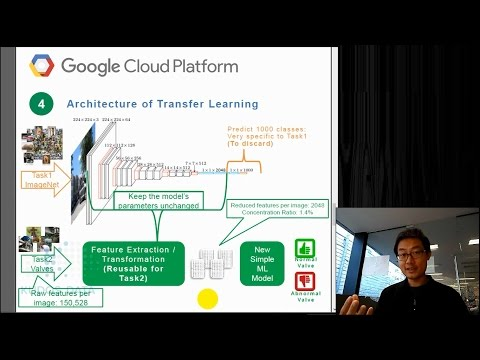

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Bh443uea-U4')

# Image Analysis Lab

### Detect Normal or Abnormal Industrial Valves, Using Transfer Learning Technology upon Google's Pre-Trained Deep Neural Network

The use case here is to use drone to provide regular surveillance on remote or dangerous areas, capturing image of industrial equipment like valves, then send the image back for automatic malfunction diagnosis, using machine intelligence. This improves safety and efficiency compared to current human-involved processes, without large investment on wired sensor infrastructure. The core part of this solution involves advanced image analysis in real world.


In this lab, you will carry out a transfer learning example based on Google Inception-v3 image recognition neural network.


### You will learn:
* Explore images in customer’s industry.
* Reposition a pre-trained deep neural net for new image recognition task.
* Perform feature extraction.
* Obtain deep feature representation of customer’s original image.
* Train a simple machine learning model for new classification task.
* Evaluate results of this transfer learning model.

# 1. Explore images in customer’s industry.
Let's have a look at the problem regarding real valve images, in 'images' directory:

### 1.1 Normal Valves:

<img align="left" src='images/normal_valve_41.jpg' width=20%>
<img align="left" src='images/normal_valve_07.jpg' width=20%>
<img align="left" src='images/normal_valve_05.jpg' width=20%>
<img align="left" src='images/normal_valve_02.jpg' width=20%>

### 1.2 Abormal Valves:

<img align="left" src='images/abnormal_valve_09.jpg' width=20%>
<img align="left" src='images/abnormal_valve_49.jpg' width=20%>
<img align="left" src='images/abnormal_valve_18.jpg' width=20%>
<img align="left" src='images/abnormal_valve_20.jpg' width=20%>

By: **Sam Gu** [ Data Science Trainer ]


May 2017


Credit: This python notebook was adapted based on: https://www.kernix.com/blog/image-classification-with-a-pre-trained-deep-neural-network_p11

### 1.3 Google's Inception-v3 Deep Neural Network Model

The pre-trained deep learning model we shall use here is Inception-v3. It has been developed by Google and has been trained for the ImageNet Competition.

<img align="left" src='https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png' width=90%>

We have downloaded this pre-trained Inception model at: 'reference/reusable_model/classify_image_graph_def.pb'. If you want to re-download this model, run: 
> !python reference/classify_image.py --model_dir reference/reusable_model

# 2. Reposition a pre-trained deep neural net for new image recognition task.

In [2]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
from tensorflow.contrib import learn
import numpy as np
import pandas as pd
import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from IPython.core.display import Image, display

print('TensorFlow Verions: %s' % tf.__version__)

/home/iss-user/anaconda3/envs/iss-env-py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


TensorFlow Verions: 1.6.0


In [3]:
model_dir = 'reference/reusable_model/'
images_dir = 'images/'
list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]
print('Number of Customer\'s Images       : %d' % len(list_images))

Number of Customer's Images       : 100


To use TensorFlow, you should define a graph that represents the description of computations. Then these computations will be executed within what is called sessions. If you want to know more about the basics of TensorFlow, you can go to: https://www.tensorflow.org/

The following function creates a graph from the graph definition that we just downloaded and that is saved in classify_image_graph_def.pb

In [4]:
def create_graph():
  with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

# 3. Perform feature extraction

Next step is to extract relevant **deep features**.

To do so, we retrieve the **next-to-last** layer of the Inception-v3 as a feature vector for each image. The last layer of the convolutional neural network corresponds to the very specific ImageNet classification task, the categories that it will be output will not be useful to our valve image diagnosis.

While the output of the next-to-last layer are more generic for image feature enrichment. These deep features are useful for **transfer learning** another classification task, so we extract the output of this layer. In TensorFlow, this layer is called **bottleneck pool_3**.


<img align="left" src='reference/note_slide/note_slide_06.JPG' width=60%>


Define following function to generate deep features corresponding to the output of **bottleneck** layer and the labels (**abnormal_valve** & **normal_valve** based on file name) for each customer image.

In [5]:
def extract_features(list_images):
  nb_features = 2048
  features = np.empty((len(list_images),nb_features)) # Deep Features to be stored here
  labels = [] # Image class labels to be stored here

  create_graph() # Create a TensorFlow computation graph
  
  with tf.Session() as sess:
    next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0') # We want the output features from this layer of Inception model
    
    for ind, image in enumerate(list_images):
      if (ind%10 == 0):
        print('Processing %s ...' % (image))
      if not gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
          
      image_data = gfile.FastGFile(image, 'rb').read()
      predictions = sess.run(next_to_last_tensor,
                             {'DecodeJpeg/contents:0': image_data})
      features[ind,:] = np.squeeze(predictions) # Store the output deep features for images
      labels.append(re.split('_\d+',image.split('/')[1])[0]) # Get class label based on file names: Class + '_' + Digits + .jpg|JPG
          
    print('')
    print('Processing Completed !')
    return features, labels

# 4. Obtain deep feature representation of customer’s original image.

Execute deep feature generation for each valve image:

In [6]:
features, labels = extract_features(list_images)

Processing images/abnormal_valve_01.jpg ...
Processing images/abnormal_valve_11.jpg ...
Processing images/abnormal_valve_21.jpg ...
Processing images/abnormal_valve_31.jpg ...
Processing images/abnormal_valve_41.jpg ...
Processing images/normal_valve_01.jpg ...
Processing images/normal_valve_11.jpg ...
Processing images/normal_valve_21.jpg ...
Processing images/normal_valve_31.jpg ...
Processing images/normal_valve_41.jpg ...

Processing Completed !


In [7]:
print('Number of Images Processed         : %d' % len(features))
print('Unique Image Classes (Labels)      : %s' % list(set(labels)))
print('Number of Deep Features per Images : %d <<<<<<<< Question here: Why 2048?' % len(features[0]))
print('An Image\'s Deep Features           : %s' % features[0])

Number of Images Processed         : 100
Unique Image Classes (Labels)      : ['normal_valve', 'abnormal_valve']
Number of Deep Features per Images : 2048 <<<<<<<< Question here: Why 2048?
An Image's Deep Features           : [ 1.29554236  0.21206838  0.31439388 ...,  0.47307667  0.9416728
  0.74598676]


In [8]:
# [Optional] Export deep features and label to CSV
import pandas as pd 
df = pd.DataFrame(features,labels)
df.to_csv("df_image_deep_features.csv")

For TensorFlow machine learning model, transform label to number: **'normal_valve' -> 0** & **'abnormal_valve' -> 1**

In [9]:
labels_number = []
for i in range(len(labels)):
  if labels[i] == 'abnormal_valve': labels_number.append(1)
  else: labels_number.append(0)
print(labels)
print(labels_number)

['abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'abnormal_valve', 'normal_valve', 'normal_valve', 'normal_valve', 'normal_valve', 'normal_valve', 'normal_valve', 'no

Then the features and labels are saved, so they can be used without re-running above slow deep feature generation.

In [10]:
pickle.dump(features, open('reference/features', 'wb'))
pickle.dump(labels_number, open('reference/labels_number', 'wb'))
pickle.dump(labels, open('reference/labels', 'wb'))

# 5. Train a simple machine learning model for new classification task.

We will now use the deep features that we just generated to train a new machine leaning classifier/model on the valve images. Another strategy could be to re-train the last layer of the deep neural net in TensorFlow: https://www.tensorflow.org/tutorials/image_retraining

<img align="left" src='reference/note_slide/note_slide_07.JPG' width=60%>

### 5.1 Prepare training and test datasets:

In [11]:
# Python 3
features      = pickle.load(open('reference/features', 'rb'))
labels_number = pickle.load(open('reference/labels_number', 'rb'))

# Python 2
# features      = pickle.load(open('reference/features'))
# labels_number = pickle.load(open('reference/labels_number'))

### 5.2 We will use 75% of the data for training and 25% for testing/prediction.

In [12]:
image_features_train, image_features_test, image_label_train, image_label_test = cross_validation.train_test_split(
  features, labels_number, test_size=0.25, random_state=1)

### 5.3 Classifying the images with a simple TensorFlow linear model:
We now chose a simple TensorFlow model to diagnose valve images into binary classes using deep features as input.

Machine learning model's pattern

    estimator         : Choose a machine learning model to use. (Here we use: LinearClassifier)
    estimator.fit     : Train the model iteratively.
    estimator.predict : Use the trained model to retrieve predictions.

In [13]:
n_classes = len(set(image_label_train))
estimator = learn.LinearClassifier(feature_columns = 
                        [tf.contrib.layers.real_valued_column("", dimension=image_features_train.shape[1])], n_classes=n_classes)
estimator.fit(image_features_train, image_label_train, steps=50)
image_label_predicted = list(estimator.predict(image_features_test))
print('')
print('===================================================')
print('TensorFlow machine learning completed successfully!')
print('===================================================')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8ea43299e8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmpcwv0yu5z'}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for 

# 6. Evaluate results of this transfer learning model.

### 6.1 Evaluation of Model Performance using Accuracy Score:

In [14]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(image_label_test, image_label_predicted)*100))

Accuracy: 96.0%


### 6.2 Evaluation of Model Performance using Confusion Matrix:

<img style="float: left;" width="50%" src="https://i.ytimg.com/vi/AOIkPnKu0YA/maxresdefault.jpg">

Confusion matrix of the classifier
[[14  0]
 [ 1 10]]


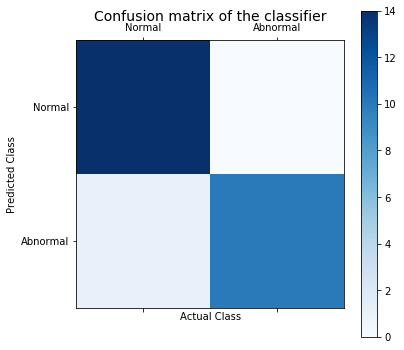

In [15]:
# Calculate Confusion matrix
cmlabels = list(set(labels_number)) # 0: Normal | 1: Abnormal
cm = confusion_matrix(image_label_predicted, image_label_test, cmlabels)
print('Confusion matrix of the classifier')
print(cm)

# Visualize Confusion matrix
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
'''
Color Map (cmap) possible values are: 
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, 
Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, 
PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, 
PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, 
RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, 
Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, 
afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, 
coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, 
gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, 
gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, 
inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, 
plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, 
spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
'''
cax = ax.matshow(cm, cmap=plt.get_cmap('Blues'))
plt.title(u'Confusion matrix of the classifier', fontsize=14)
fig.colorbar(cax)
# ax.set_xticklabels([''] + cmlabels)
# ax.set_yticklabels([''] + cmlabels)
ax.set_xticklabels([''] + ['Normal', 'Abnormal'])
ax.set_yticklabels([''] + ['Normal', 'Abnormal'])
plt.xlabel(u'Actual Class')
plt.ylabel(u'Predicted Class')
plt.show()

### 6.3 Let's have a look at those valve images diagnosed incorrectly:

Below are images incorrectly predicted, with their actual class:


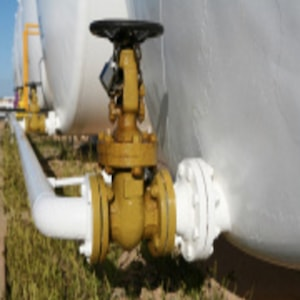

'images/normal_valve_32.jpg'

In [16]:
# Create a list containing bad predictions
wrong_prediction_index_list = []
for i in range(len(image_label_predicted)): 
  if image_label_predicted[i] != image_label_test[i]: wrong_prediction_index_list.append(i)
wrong_image_index_list = []
for j in range(len(wrong_prediction_index_list)): 
  for k in range(len(features)):
    if np.array_equal(image_features_test[wrong_prediction_index_list[j]], features[k]): wrong_image_index_list.append(k)

# Display image & acutal class below the image
print('================================================================')
print('Below are images incorrectly predicted, with their actual class:')
print('================================================================')
for m in range(len(wrong_image_index_list)): 
    display(Image(list_images[wrong_image_index_list[m]]), list_images[wrong_image_index_list[m]])

***[Take Away Question] Is there ways to further improve the prediction accuracy? Yes there are! You can find more from ... advanced GCP courses.***

<img align="left" src='https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png' width=90%>

# Congratulations! You are now equipped with practical skills to carry out deep leaning image analysis in real world!

### You have learnt:

* Deep Learning Basics for Image Analysis
* Real World Image Analysis Needs
* Idea of Transfer Learning
* Architecture of Transfer Learning
* Hands-on Datalab Workshop on GCP

# Questions & Answers session for lecture and lab workshop

---